In [14]:

import os

print(os.getcwd())
os.chdir(os.path.abspath("../src"))  # 将执行路径改为src目录下
print(os.getcwd())

D:\Architecture\AAA-Master\24Fall\RoadNetOpt\RoadNetOpt\src
D:\Architecture\AAA-Master\24Fall\RoadNetOpt\RoadNetOpt\src


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

In [71]:
from geo import RoadCollection
from utils import io_utils

# 导入地图资源
data = io_utils.load_data('../data/和县/data.bin')
road_collection = RoadCollection()
road_collection.data_to_roads(data)

In [72]:
road_collection.auto_fix()

In [73]:
G = road_collection.to_graph()

roads_to_graph 转换耗时 44.301509857177734 ms


In [74]:
G

In [48]:
for uid, data in G.nodes(data=True):
    print(uid)
    print(data)
    break

43
{}


In [49]:
import networkx as nx

pos = {uid: (data['x'], data['y']) for uid, data in G.nodes(data=True)}
nx.draw(G, pos=pos, node_color='lightblue', node_size=5, )
# 设置 x 和 y 轴比例一致
plt.axis('equal')
plt.show()

KeyError: 'x'

In [51]:
cycles = nx.cycle_basis(G)


In [52]:
len(cycles)

236

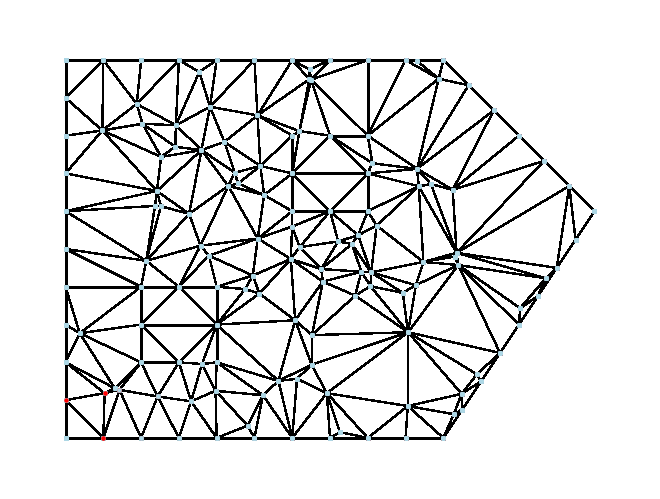

In [44]:
os.makedirs("./cycles", exist_ok=True)
for i, cycle in enumerate(cycles):
    subgraph = G.subgraph(cycle)
    nx.draw(G, pos=pos, node_color='lightblue', node_size=5, )
    nx.draw(subgraph, pos=pos, node_color='red', node_size=5, )
    plt.axis('equal')
    plt.savefig(f"./cycles/{i:05d}.jpg")

In [55]:
import numpy as np


def draw_polygon(points, edge_color='blue', fill_color='lightblue', point_color='blue'):
    if not isinstance(points, np.ndarray):
        points = np.array(points)
    assert len(points.shape) == 2
    if not np.array_equal(points[0], points[-1]):  # 如果提供的点不是闭合的点
        points = np.concatenate((points, [points[0]]))
    x, y = points[:, 0], points[:, 1]
    if edge_color is not None:
        plt.plot(x, y, color=edge_color)
    if fill_color is not None:
        plt.fill(x, y, color=fill_color)
    if point_color is not None:
        plt.scatter(x, y, color=point_color)

def draw_points(points, point_color='blue'):
    if not isinstance(points, np.ndarray):
        points = np.array(points)
    assert len(points.shape) == 2
    plt.scatter(points[:, 0], points[:, 1], color=point_color)

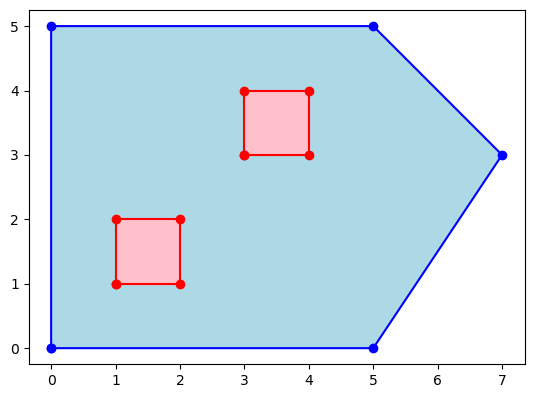

In [56]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# 定义外部边界点坐标
outer_points = np.array([(0, 0), (0, 5), (5, 5), (7, 3), (5, 0)])

# 定义内部洞的点坐标
inner_points_list = [np.array([(1, 1), (1, 2), (2, 2), (2, 1)]),
                     np.array([(3, 3), (3, 4), (4, 4), (4, 3)])]

draw_polygon(outer_points, edge_color='blue', fill_color='lightblue', point_color='blue')
# 绘制内部洞
for inner_points in inner_points_list:
    draw_polygon(inner_points, edge_color='red', fill_color='pink', point_color='red')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [57]:
import math


def interpolate_points_by_distance(points, distance):
    assert isinstance(points, np.ndarray)
    assert len(points.shape) == 2
    if not np.array_equal(points[0], points[-1]):
        # 如果提供的点不是闭合的点
        points = np.concatenate((points, [points[0]]))
    result = []
    for i in range(len(points) - 1):
        pt1 = points[i]
        pt2 = points[i + 1]
        length = np.linalg.norm(pt1 - pt2)
        if length <= distance:
            result.append(pt1)
            continue
        num_seg = int(math.ceil(length / distance))
        seg_length = length / num_seg
        vec = (pt2 - pt1) / length * seg_length
        for j in range(num_seg):
            result.append(pt1 + vec * j)
    return np.array(result)



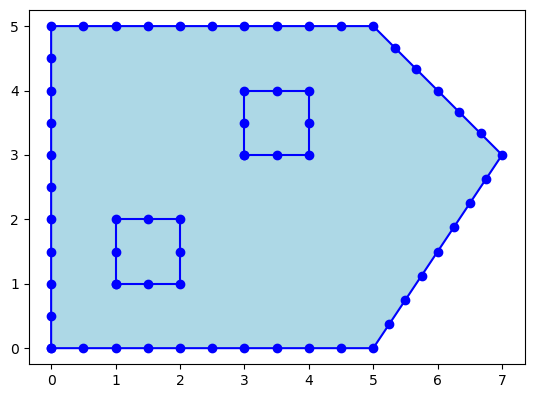

In [58]:
new_outer_points = interpolate_points_by_distance(outer_points, 0.5)
new_inner_points_list = [interpolate_points_by_distance(inner_points, 0.5) for inner_points in inner_points_list]

draw_polygon(new_outer_points)
for new_inner_points in new_inner_points_list:
    draw_polygon(new_inner_points)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [59]:

def is_points_inside_region(points, region_points):
    assert isinstance(region_points, np.ndarray)
    assert len(region_points.shape) == 2
    assert isinstance(points, np.ndarray)
    assert len(points.shape) == 2

    if not np.array_equal(region_points[0], region_points[-1]):
        # 如果提供的region points不是闭合的点
        region_points = np.concatenate((region_points, [region_points[0]]))
    result = np.empty((len(points),), dtype=bool)
    for i, point in enumerate(points):
        inside = True
        for j in range(len(region_points) - 1):
            pt1 = region_points[j]
            pt2 = region_points[j + 1]
            vec1 = pt2 - pt1
            vec2 = point - pt1
            if np.cross(vec1, vec2) > 0:
                inside = False
                break
        result[i] = inside
    return result

In [60]:
def get_points_bound(points):
    min_x = np.min(points[:, 0])
    min_y = np.min(points[:, 1])
    max_x = np.max(points[:, 0])
    max_y = np.max(points[:, 1])
    return min_x, min_y, max_x, max_y
def spawn_random_points(num_points: int, bound:tuple):
    min_x, min_y, max_x, max_y = bound
    # 在指定范围内生成随机均匀分布的点
    x_points = np.random.uniform(min_x, max_x, num_points)
    y_points = np.random.uniform(min_y, max_y, num_points)
    points = np.column_stack((x_points, y_points))
    return points


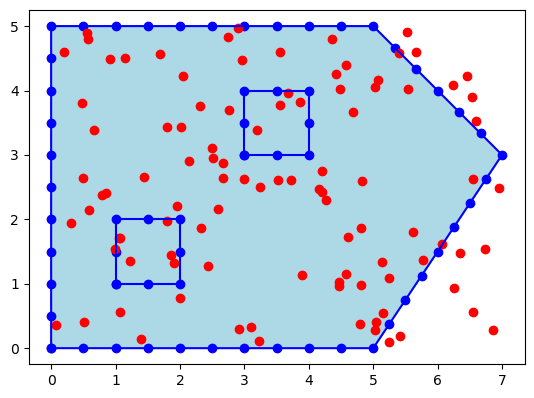

In [61]:
candidate_points = spawn_random_points(100, get_points_bound(new_outer_points))

draw_polygon(new_outer_points)
for new_inner_points in new_inner_points_list:
    draw_polygon(new_inner_points)
draw_points(candidate_points, point_color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [62]:
inside_outer = is_points_inside_region(candidate_points, outer_points)
inside_inner = np.array([is_points_inside_region(candidate_points, inner_points) for inner_points in inner_points_list]).T
any_inside_inner = np.any(inside_inner, axis=1)

inside_mask = inside_outer & ~any_inside_inner

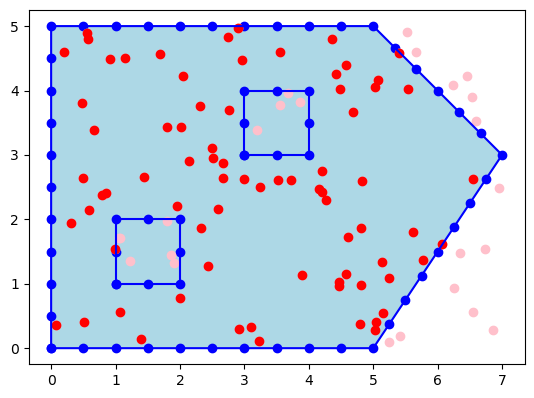

In [63]:
inside_points = candidate_points[inside_mask]

draw_polygon(new_outer_points)
for new_inner_points in new_inner_points_list:
    draw_polygon(new_inner_points)
draw_points(candidate_points, point_color='pink')
draw_points(inside_points, point_color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [64]:
points_to_delaunay = np.concatenate([new_outer_points] + new_inner_points_list + [inside_points])
points_to_delaunay.shape

(136, 2)

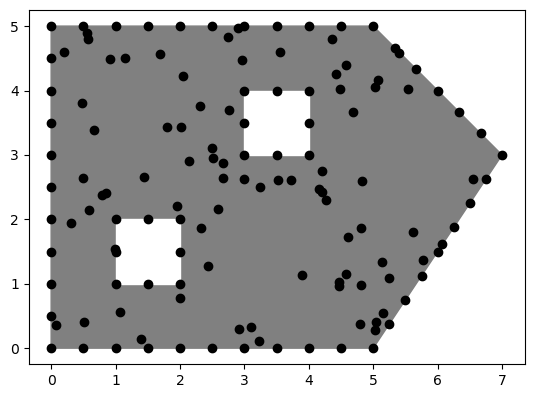

In [65]:
draw_polygon(new_outer_points, edge_color=None, fill_color='gray', point_color=None)
for new_inner_points in new_inner_points_list:
    draw_polygon(new_inner_points, edge_color=None, fill_color='white', point_color=None)
draw_points(points_to_delaunay, point_color='black')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [36]:
from scipy.spatial import Delaunay
tri = Delaunay(points_to_delaunay)

In [66]:
for indices in tri.simplices:
    print(indices)
    break

[43  1  0]


In [67]:
# 创建一个 NetworkX 图
G = nx.Graph()
# 将三角形的边添加到图中
for indices in tri.simplices:
    edge1 = (indices[0], indices[1])
    edge2 = (indices[1], indices[2])
    edge3 = (indices[2], indices[0])
    G.add_edges_from([edge1, edge2, edge3])

In [39]:
pos = {i: points_to_delaunay[i] for i in range(len(points_to_delaunay))}

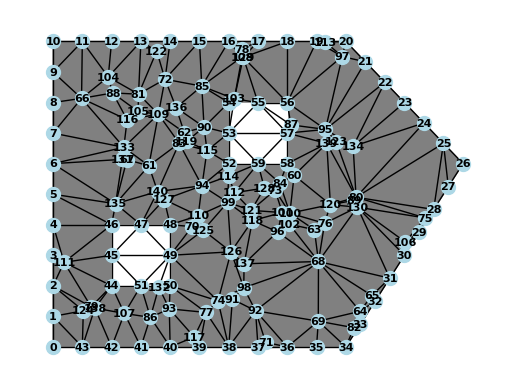

In [40]:
draw_polygon(new_outer_points, edge_color=None, fill_color='gray', point_color=None)
for new_inner_points in new_inner_points_list:
    draw_polygon(new_inner_points, edge_color=None, fill_color='white', point_color=None)
# draw_points(points_to_delaunay, point_color='black')
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=100, font_weight='bold', font_color='black', font_size=8)
plt.show()

In [69]:
# 获取每条边的中心点
center_points = []
for u, v in G.edges():
    center_x = (pos[u][0] + pos[v][0]) / 2
    center_y = (pos[u][1] + pos[v][0]) / 2
    center_points.append([center_x, center_y])

# 将中心点整合为一个数组
edge_center_points = np.array(center_points)